In [1]:
#import all libraries

import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [2]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(

    directory = "PlantVillage",
    batch_size=32,
    seed = 123,
    shuffle = True,
    image_size = [255,255]

)

Found 2152 files belonging to 3 classes.


In [3]:
classname = dataset.class_names

In [4]:
len(dataset)

68

In [5]:
import numpy as np
for batch_size,label_size in dataset.take(1):
    print("image size:", batch_size.shape)
    print("batch:", label_size.numpy)
    print("image",batch_size[0])

image size: (32, 255, 255, 3)
batch: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 2, 0, 0], dtype=int32)>>
image tf.Tensor(
[[[141.98236  115.98237  116.98237 ]
  [136.82382  110.823814 111.823814]
  [107.35246   81.35246   82.35246 ]
  ...
  [173.01381  155.01381  151.01381 ]
  [181.93741  163.93741  159.93741 ]
  [195.95111  177.95111  173.95111 ]]

 [[137.87445  111.87446  112.87446 ]
  [136.8248   110.82481  111.82481 ]
  [132.12982  106.129814 107.129814]
  ...
  [175.0646   157.0646   153.0646  ]
  [176.98244  158.98244  154.98244 ]
  [184.96088  166.96088  162.96088 ]]

 [[117.12743   91.12743   92.12743 ]
  [112.31633   86.31633   87.31633 ]
  [144.35968  118.35967  119.35967 ]
  ...
  [176.0387   158.0387   154.0387  ]
  [176.02917  158.02917  154.02917 ]
  [181.049    163.049    159.049   ]]

 ...

 [[107.330246  81.330246  80.330246]
  

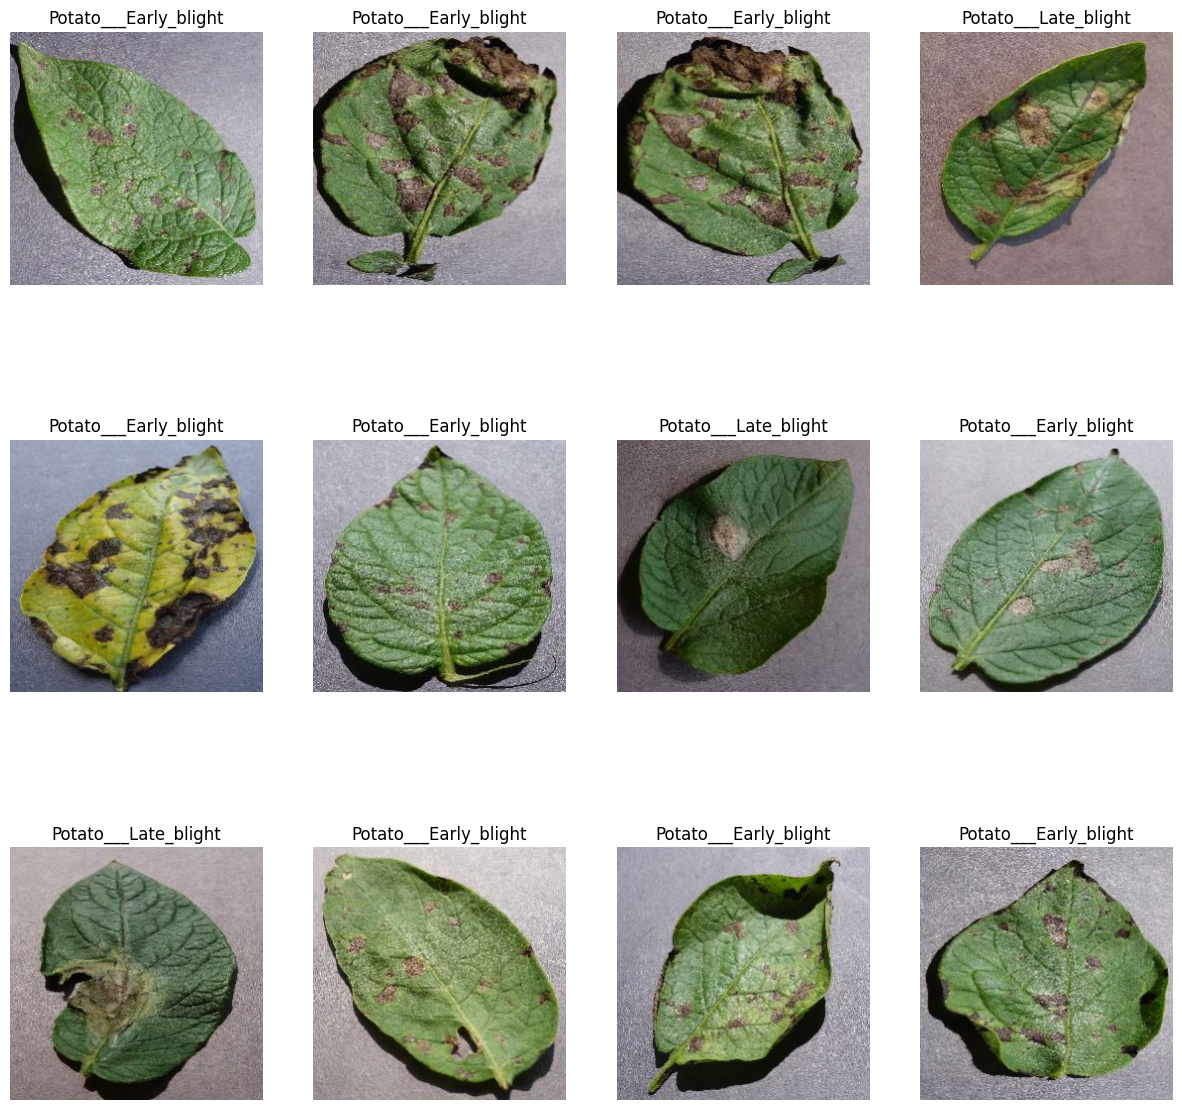

In [6]:
plt.figure(figsize=(15,15))
for image,label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classname[label[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)

In [9]:
test_ds = dataset.skip(54)

In [10]:
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size


6.800000000000001

In [12]:
val_ds = dataset.take(6)
test_ds = test_ds.skip(6)


In [13]:
len(train_ds)

54

In [14]:
len(test_ds)

8

In [15]:
len(val_ds)

6

In [16]:
def dataset_partion_tf(ds,train_split = 0.8, val_split = 0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split + test_split+val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds
train_ds,val_ds,test_ds = dataset_partion_tf(dataset)

    


In [17]:
len(train_ds)

54

In [18]:
len(test_ds)


8

In [19]:
len(val_ds)

6

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(255,255),
    layers.Rescaling(1.0 / 255)
])

In [22]:
# data augumentation
data_augmentation = Sequential([

    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),  # Randomly rotate images by 20%

])

In [23]:
train_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y)).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)), 
    layers.MaxPooling2D((2, 2)),  

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    

    # Flatten layer
    layers.Flatten(),  # Converts the 3D feature maps to 1D feature vectors

    # Fully connected (Dense) layer
    layers.Dense(128, activation='relu'),  # 128 neurons

    # Output layer
    layers.Dense(64,activation='softmax')  
])




c:\Users\Komal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=32,
    validation_data=val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5740 - loss: 1.6288 - val_accuracy: 0.8854 - val_loss: 0.4620
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8566 - loss: 0.3846 - val_accuracy: 0.8854 - val_loss: 0.3166
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8810 - loss: 0.3274 - val_accuracy: 0.9323 - val_loss: 0.1934
Epoch 4/20
48/54 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9164 - loss: 0.2117

In [ ]:
model.save("model.h5")

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
for img,label in test_ds.take(1):
    first_img = img[0].numpy().astype('uint8')
    first_label = label[0].numpy()

    pred_img = model.predict(img)
    plt.imshow(first_img)
    print(classname[first_label])
    print(classname[np.argmax(pred_img[0])])


In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)
    predicted_class = classname[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence